In [293]:
from datetime import datetime
import numpy as np
import pandas as pd

In [444]:
def group_adjust(vals, groups, weights):
    """
    Calculate a group adjustment (demean).

    Parameters
    ----------

    vals    : List of floats/ints

        The original values to adjust

    groups  : List of Lists

        A list of groups. Each group will be a list of ints

    weights : List of floats

        A list of weights for the groupings.
        
    safe: Boolean [False,True]
            A little bit of error checking

    Returns
    -------

    A list-like demeaned version of the input values
    """
    # lets make python semi strongly-typed , somedecade v4.0?
    # negliable overhead, besides time order constant
    if not isinstance(vals,list):
        raise TypeError('vals not  of type list')
    if not isinstance(groups[0],list):
        raise TypeError('groups not of type list of lists')
    if not isinstance(weights,list):
        raise TypeError('Weight not  of type list')
    if (len(weights) != len(groups)):
        raise ValueError('test_weights_len_nequals_group_len {} != {}'.format(len(weights),len(groups)))  

            
    vals = np.array(vals)  

    # convert into array, which enables elimination of sopurious nan(s).
        # dont need as pandas does for us
#    vals = vals[np.logical_not(np.isnan(vals))]

    #create dataframe of passed lists.
    arg_dic = {'vals':vals}
    for i in range(len(groups)):
        arg_dic['group_'+ str(i+1)] = groups[i]

    df = pd.DataFrame(arg_dic)
    
    #create df of means
    means = df.groupby(['group_1'])['vals'].agg(['mean'])
    for i in range(1,len(groups)):
        means = pd.concat([ means,df.groupby(['group_'+ str(i+1)])['vals'].agg(['mean'])])

    #transform into group names into means and broadcast in weights
#    demeaned = pd.DataFrame(groups,dtype='str')
    # take out dtype='str' to speed up 1.4x
    demeaned = pd.DataFrame(groups)

    # v.0.0.1 slowwwww
    #apply function is a linear operation, processing 
    # the function at O(n) complexity. n here is nrows x ncolums
#    demeaned = groupdf.applymap(lambda x:  means.loc[x].values[0])

# v0.0.2 try some broadcasting to substitute in mean for symbol
# about 25x faster
# next 1. numpy 2. jit or cpython
    for rr in range(means.index.T.shape[0]):
        for r in range(demeaned.shape[0]):
            demeaned.iloc[r][demeaned.iloc[r]\
                             ==means.index.T[rr]]=means['mean'].loc[means.index.T[rr]]

    demeaned_results = demeaned.T*weights*-1

# put in mean index , reset_index ? not worth breaking right now
    demeaned_results['row_id'] = range(demeaned_results.shape[0])
    demeaned_results['row_id'] +=1
    # transpose so we can sun over rows
    results = demeaned_results.T.sum(axis=0).round(3)

    return list(results)


In [423]:
iter = 1000
vals = [1, 2, 3, 8, 5]*iter
grps_1 = ['USA', 'USA', 'USA', 'USA', 'USA']*iter
grps_2 = ['MA', 'MA', 'MA', 'RI', 'RI']*iter
grps_3 = ['WEYMOUTH', 'BOSTON', 'BOSTON', 'PROVIDENCE', 'PROVIDENCE']*iter
weights = [.15, .35, .5]

group_adjust(vals, [grps_1, grps_2, grps_3], weights)
x=1


In [424]:
def test_three_groups():
    vals = [1, 2, 3, 8, 5]
    grps_1 = ['USA', 'USA', 'USA', 'USA', 'USA']
    grps_2 = ['MA', 'MA', 'MA', 'RI', 'RI']
    grps_3 = ['WEYMOUTH', 'BOSTON', 'BOSTON', 'PROVIDENCE', 'PROVIDENCE']
    weights = [.15, .35, .5]

    adj_vals = group_adjust(vals, [grps_1, grps_2, grps_3], weights)
    # 1 - (USA_mean*.15 + MA_mean * .35 + WEYMOUTH_mean * .5)
    # 2 - (USA_mean*.15 + MA_mean * .35 + BOSTON_mean * .5)
    # 3 - (USA_mean*.15 + MA_mean * .35 + BOSTON_mean * .5)
    # etc ...
    # Plug in the numbers ...
    # 1 - (.15 * 3.8 + .35 * 2.0 + .5 * 1.0) = -0.770
    # 2 - (.15 * 3.8 + .35 * 2.0 + .5 * 2.5) = -0.520
    # 3 - (.15 * 3.8 + .35 * 2.0 + .5 * 2.5) =  0.480
    # etc...

    answer = [-0.770, -0.520, 0.480, -2.095, -1.095]
    for ans, res in zip(answer, adj_vals):
        assert abs(ans - res) < 1e-5
    return True
test_three_groups()

True

In [425]:
def test_two_groups():
    vals = [1, 2, 3, 8, 5]
    grps_1 = ['USA', 'USA', 'USA', 'USA', 'USA']
    grps_2 = ['MA', 'RI', 'CT', 'CT', 'CT']
    weights = [.65, .35]

    adj_vals = group_adjust(vals, [grps_1, grps_2], weights)
    # 1 - (.65 * 3.8 + .35 * 1.0) = -1.82
    # 2 - (.65 * 3.8 + .35 * 2.0) = -1.17
    # 3 - (.65 * 3.8 + .35 * 5.33333) = -1.33666
    answer = [-1.82, -1.17, -1.337, -0.337, 0.663]
    for ans, res in zip(answer, adj_vals):
        assert abs(ans - res) < 1e-5
    return True
test_two_groups()
#[-1.82, -1.17, -1.337, -0.337, 0.663]

True

In [437]:
def test_missing_vals():
    # If you're using NumPy or Pandas, use np.NaN
    # If you're writing pyton, use None
    vals = [1,  np.NaN, 3, 5, 8, 7]
    # vals = [1, None, 3, 5, 8, 7]
    grps_1 = ['USA', 'USA', 'USA', 'USA', 'USA', 'USA']
    grps_2 = ['MA', 'RI', 'RI', 'CT', 'CT', 'CT']
    weights = [.65, .35]

    adj_vals = group_adjust(vals, [grps_1, grps_2], weights)

    # This should be None or np.NaN depending on your implementation
    # please feel free to change this line to match yours
    answer = [-2.47, -2.17, -1.170, -1.453, -0.453, 0.547]
    # answer = [-2.47, None, -1.170, -0.4533333, 2.54666666, 1.54666666]

    for ans, res in zip(answer, adj_vals):
        if ans is None:
            assert res is None
        elif np.isnan(ans):
            assert np.isnan(res)
        else:
            assert abs(ans - res) < 1e-5
        return True
test_missing_vals()

True

In [432]:
def test_group_len_equals_vals_len():
    # The groups need to be same shape as vals
    vals = [1, 1, 3, 5, 8, 7], 3, 5, 8, 7]
    grps_1 = ['USA']
    grps_2 = ['MA', 'RI', 'RI', 'CT', 'CT', 'CT']
    weights = [.15, .35, .5]


    group_adjust(vals, [grps_1, grps_2], weights)

    
test_weights_len_equals_group_len()

ValueError: test_weights_len_nequals_group_len 1 != 2

In [438]:
def test_performance(iter):
    vals = [1, np.NaN, 3, 8, 5]*iter
    grps_1 = ['USA', 'USA', 'USA', 'USA', 'USA'] *iter
    grps_2 = ['MA', 'MA', 'MA', 'RI', 'RI'] *iter
    grps_3 = ['WEYMOUTH', 'BOSTON', 'BOSTON', 'PROVIDENCE', 'PROVIDENCE']*iter
    weights = [.15, .35, .5]

    start = datetime.now()
    group_adjust(vals, [grps_1, grps_2, grps_3], weights)
    end = datetime.now()
    diff = end - start
    return diff

In [439]:
test_performance(1000)

datetime.timedelta(microseconds=600678)

1,000 = 8/0.6  14x

10,000  = 90.4/5.55 sec 15x

100,000 = 1,437/56 sec  25x

1,000,000 = /57 sec

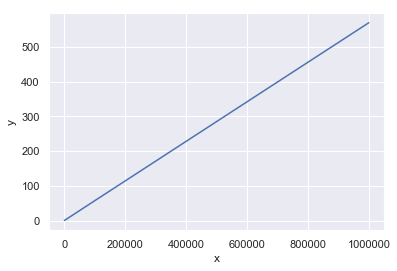

In [442]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
y = [0.6 ,5.55, 57, 569]
x = [1.0e03,10*1.0e03 ,100*1.0e03 ,1000*1.0e03 ]
df = pd.DataFrame({'x': x, 'y': y })
ax = sns.lineplot(x="x", y="y", data=df)

